<h1>RESTRICTED BOLTZMANN MACHINES</h1>

<b>Restricted Boltzmann Machine (RBM):</b>  RBMs are shallow neural nets that learn to reconstruct data by themselves in an unsupervised fashion. It can automatically extract <b>meaningful</b> features from a given input.

RBM is a 2 layer neural network. Simply, RBM takes the inputs and translates those into a set of binary values that represents them in the hidden layer. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns. RBM is useful for Collaborative Filtering, dimensionality reduction, classification, regression, feature learning, topic modeling and even <b>Deep Belief Networks</b>.

<h4>Is RBM a generative or Discriminative model?</h4>

RBM is a generative model. Let's see what is different between discriminative and generative models: 

<b>Discriminative:</b> Consider a classification problem in which we want to learn to distinguish between Sedan cars (y = 1) and SUV cars (y = 0), based on some features of cars. Given a training set, an algorithm like logistic regression tries to find a straight line—that is, a decision boundary—that separates the suv and sedan.

<b>Generative:</b> looking at cars, we can build a model of what Sedan cars look like. Then, looking at SUVs, we can build a separate model of what SUV cars look like. Finally, to classify a new car, we can match the new car against the Sedan model, and match it against the SUV model, to see whether the new car looks more like the SUV or Sedan. 

Generative Models specify a probability distribution over a dataset of input vectors. We can do both supervise and unsupervised tasks with generative models:
- In an unsupervised task, we try to form a model for P(x), where P is the probability given x as an input vector.
- In the supervised task, we first form a model for P(x|y), where P is the probability of x given y(the label for x). For example, if y = 0 indicates whether a car is a SUV or y = 1 indicates indicate a car is a Sedan, then p(x|y = 0) models the distribution of SUVs’ features, and p(x|y = 1) models the distribution of Sedans’ features. If we manage to find P(x|y) and P(y), then we can use `Bayes rule` to estimate P(y|x), because:  

$$ p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$

In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar


def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0)):
    """
    Transform an array with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.

    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).

    :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
    be 2-D ndarrays or None;
    :param X: a 2-D array in which every row is a flattened image.

    :type img_shape: tuple; (height, width)
    :param img_shape: the original shape of each image

    :type tile_shape: tuple; (rows, cols)
    :param tile_shape: the number of images to tile (rows, cols)

    :returns: array suitable for viewing as an image.
    :rtype: a 2-d array with same dtype as X.

    """
    
    out_shape = [
        (ishp + tsp) * tshp - tsp
        for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)
    ]

    if isinstance(X, tuple):
        # Create an output numpy ndarray to store the image
        out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
        channel_defaults = [0, 0, 0, 255]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct dtype
                out_array[:, :, i] = np.zeros(out_shape, dtype='uint8') + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it in the output
                out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape, tile_spacing)
                
        return out_array

    else:
        # we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing
        out_array = np.zeros(out_shape, dtype='uint8')

        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]
                    this_img = scale_to_unit_interval(this_x.reshape(img_shape))
                    c = 255
                    out_array[tile_row * (H + Hs): tile_row * (H + Hs) + H,
                              tile_col * (W + Ws): tile_col * (W + Ws) + W
                              ] = this_img * c
        return out_array

<h3>RBM layers</h3>

An RBM has two layers. The first layer of the RBM is called the <b>visible</b> (or input layer). Let's imagine that our example, has only vectors with 7 values, so the visible layer must have j=7 input nodes. The second layer is the <b>hidden</b> layer, which possesses i neurons in our case. Each hidden node can have either 0 or 1 values (i.e., si = 1 or si = 0) with a probability that is a logistic function of the inputs it receives from the other j visible units, called for example, p(si = 1). For our toy sample, we'll use 2 nodes in the hidden layer, so i = 2.

<img src="https://ibm.box.com/shared/static/eu26opvcefgls6vnwuo29uwp0nudmokh.png" alt="RBM Model" width=600>

Each node in the first layer also has a <b>bias</b>. We will denote the bias as “visible_bias” for the visible units. The `visible_bias` is shared among all visible units.

Here we define the <b>bias</b> of second layer as well. We will denote the bias as “hidden_bias” for the hidden units. The `hidden_bias` is shared among all hidden units

We have to define weights among the input layer and hidden layer nodes. In the weight matrix, the number of rows are equal to the input nodes, and the number of columns are equal to the output nodes. Let <b>W</b> be the Tensor of 7x2 (7 - number of visible neurons, 2 - number of hidden neurons) that represents weights between neurons. 

RBM can give us 2 things. First, it encodes our images in hidden layer. Second, it gives us the probability of observing a case, given some hidden values.

RBM has two phases:
- Forward Pass 
- Backward Pass or Reconstruction

**Forward Pass**: Input one training sample (one image) `X` through all visible nodes, and pass it to all hidden nodes. Processing happens in each node in the hidden layer. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer). At the hidden layer's nodes, `X` is multiplied by a $W_{ij}$ and added to hidden_bias. The result of those two operations is fed into the sigmoid function, which produces the node’s output, $p({h_j})$, where j is the unit number. 


$p({h_j})= \sigma(\sum_i w_{ij} x_i)$, where $\sigma()$ is the logistic function.


$p({h_j})$ is the probabilities of the hidden units. And, all values together are called `probability distribution`. That is, RBM uses inputs x to make predictions about hidden node activations. For example, imagine that the values of $h_p$ for the first training item is [0.51 0.84]. It tells you what is the conditional probability for each hidden neuron to be at Forward Pass: 

- p($h_{1}$ = 1|V) = 0.51
- p($h_{2}$ = 1|V) = 0.84  


As a result, for each row in the training set, <b>a vector/tensor</b> is generated, which in our case it is of size [1x2], and totally n vectors ($p({h})$=[nx2]). 

We then turn unit $h_j$ on with probability $p(h_{j}|V)$, and turn it off with probability $1 - p(h_{j}|V)$.

Therefore, the conditional probability of a configuration of h given v (for a training sample) is:

$$p(\mathbf{h} \mid \mathbf{v}) = \prod_{j=0}^H p(h_j \mid \mathbf{v})$$

Now, we sample a hidden activation vector <b>h</b> from this probability distribution $p({h_j})$. That is, we sample the activation vector from the probability distribution of hidden layer values. 

**Backward Pass (Reconstruction)**: The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers. So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h) play the role of input. That is, <b>h</b> becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

RBM learns a probability distribution over the input, and then, after being trained, the RBM can generate new samples from the learned probability distribution.

The (conditional) probability distribution over the visible units v is given by

$p(\mathbf{v} \mid \mathbf{h}) = \prod_{i=0}^V p(v_i \mid \mathbf{h}),$

where,

$p(v_i \mid \mathbf{h}) = \sigma\left( a_i + \sum_{j=0}^H w_{ji} h_j \right)$

so, given current state of hidden units and weights, what is the probability of generating input in reconstruction phase, based on the above <b>probability distribution</b> function?

Our objective is to train the model in such a way that the input vector and reconstructed vector to be same. Therefore, based on how different the input values look to the ones that we just reconstructed, the weights are adjusted. 


<h2>MNIST</h2>


We will be using the MNIST dataset to practice the usage of RBMs. The following cell loads the MNIST dataset.

In [3]:
(X, y), (X_test, y_test) = kr.datasets.mnist.load_data()

MNIST images have 784 pixels, so the visible layer must have 784 input nodes.  For our case, we'll use 50 nodes in the hidden layer, so i = 50.

Let <b>W</b> be the Tensor of (number of visible neurons, number of hidden neurons) that represents weights between the neurons. (784, 50)

In [4]:
input_dims = 28*28
hidden_layer = 50
alpha = 0.01

In [5]:
visible_bias = tf.placeholder(tf.float32, [input_dims])
hidden_bias = tf.placeholder(tf.float32, [hidden_layer])
W = tf.placeholder(tf.float32, [input_dims, hidden_layer])

Lets define the visible layer:

In [6]:
visible_state_0 = tf.placeholder(tf.float32, [None, input_dims])

Now, we can define hidden layer:

In [7]:
hidden_prob_0 = tf.nn.sigmoid(tf.matmul(visible_state_0, W) + hidden_bias)  # probabilities of the hidden units
hidden_state_0 = tf.nn.relu(tf.sign(hidden_prob_0 - tf.random_uniform(tf.shape(hidden_prob_0)))) # sample h given X

Now, we define reconstruction part:

In [8]:
visible_prob_1 = tf.nn.sigmoid(tf.matmul(hidden_state_0, tf.transpose(W)) + visible_bias) 
visible_state_1 = tf.nn.relu(tf.sign(visible_prob_1 - tf.random_uniform(tf.shape(visible_prob_1)))) # sample v given h

We are trying to maximize the likelihood of our data being drawn from that distribution. So, we are going to calculate error in each epoch by computing the "error" as a sum of the squared difference between step 1 and step n, e.g the error shows the difference between the data and its reconstruction.

In [9]:
err = tf.losses.mean_squared_error(visible_state_0, visible_state_1)

<h3>Train the Model</h3>

We want to give a high probability to the input data we train on. So, in order to train an RBM, we have to maximize the product of probabilities assigned to all rows v (images) in the training set V (a matrix, where each row of it is treated as a visible vector v):

$$\arg \max _{W}\prod _{v\in V}P(v)$$


Which is equivalent, maximizing the expected log probability of V:


$$\arg \max _{W}\mathbb {E} \left[\sum _{v\in V}\log P(v)\right]$$


So, we have to update the weights $W_{ij}$  to increase p(v) for all v in our training data during training. So we have to calculate the derivative:

$$\frac{\partial \log p(\mathbf v)}{\partial w_{ij}}$$

This cannot be easily done by typical gradient descent `(SGD)`, so we have to use another approach, which has 2 steps:

- Gibbs Sampling
- Contrastive Divergence    
    
#### Gibbs Sampling
First, given an input vector v we are using p(h|v) for prediction of the hidden values h. 
- $p(h|v) = sigmoid(X * W + hidden bias)$
- h0 = sampleProb(h0)
    
Then, knowing the hidden values, we use p(v|h) for reconstructing of new input values v. 
- $p(v|h) = sigmoid(h0 * W^{T} + visible bias)$
- $v1 = sampleProb(v1)$  (Sample v given h)
        
This process is repeated k times. After k iterations we obtain an other input vector vk which was recreated from original input values v0 or X.

Reconstruction steps:
- Get one data point from data set, like <i>x</i>, and pass it through the net
- Pass 0: (x)  $\Rightarrow$ (h0) $\Rightarrow$  (v1)   (v1 is reconstruction of the first pass)
- Pass 1: (v1) $\Rightarrow$  (h1) $\Rightarrow$  (v2)   (v2 is reconstruction of the second pass)
- Pass 2: (v2) $\Rightarrow$  (h2) $\Rightarrow$  (v3)   (v3 is reconstruction of the third pass)
- Pass n: (vk) $\Rightarrow$  (hk+1) $\Rightarrow$  (vk+1)(vk is reconstruction of the nth pass)
        
**What is sampling here (sampleProb)?**

In forward pass: We randomly set the values of each $h_{i}$ to be 1 with probability $sigmoid(v * W + hidden bias)$.  
- To sample h given v means to sample from the conditional probability distribution P(h|v). It means that we are asking what are the probabilities of getting a specific set of values for the hidden neurons, given the values v for the visible neurons, and sampling from this probability distribution.

In reconstruction: We randomly set the values of each vi to be 1 with probability $ sigmoid(h * W^{T} + visible bias)$.

#### Contrastive Divergence (CD-k)

The update of the weight matrix is done during the Contrastive Divergence step. Vectors v0 and vk are used to calculate the activation probabilities for hidden values h0 and hk. The difference between the outer products of those probabilities with input vectors v0 and vk results in the update matrix:

$\Delta W =v0 * h0 - vk * hk$ 

Contrastive Divergence is actually matrix of values that is computed and used to adjust values of the W matrix. Changing W incrementally leads to training of W values. Then on each step (epoch), W is updated to a new value W' through the equation below:

$W' = W + alpha * \Delta W$ 

where alpha is some small step rate and is also known as the "learning rate".

Ok, lets assume that k=1, that is we just get one more step:

In [10]:
hidden_prob_1 = tf.nn.sigmoid(tf.matmul(visible_state_1, W) + hidden_bias)
hidden_state_1 = tf.nn.relu(tf.sign(hidden_prob_1 - tf.random_uniform(tf.shape(hidden_prob_1)))) # sample h given X

In [11]:
alpha = 0.01
W_Delta = tf.matmul(tf.transpose(visible_state_0), hidden_prob_0)- \
          tf.matmul(tf.transpose(visible_state_1), hidden_prob_1)
update_w = W + alpha * W_Delta
update_visible_bias = visible_bias + alpha * tf.reduce_mean(visible_state_0 - visible_state_1, 0)
update_hidden_bias = hidden_bias + alpha * tf.reduce_mean(hidden_state_0 - hidden_state_1, 0)

Let's start a session and initialize the variables:

In [12]:
cur_w = np.zeros([input_dims, hidden_layer], np.float32)
prv_w = np.zeros([input_dims, hidden_layer], np.float32)

cur_visible_bias = np.zeros([input_dims], np.float32)
prv_visible_bias = np.zeros([input_dims], np.float32)

cur_hidden_bias = np.zeros([hidden_layer], np.float32)
prv_hidden_bias = np.zeros([hidden_layer], np.float32)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
X = X / 255
X = X.reshape((-1, input_dims))

Lets look at the error of the first run:

In [14]:
sess.run(err, feed_dict={visible_state_0: X, 
                         W: prv_w, 
                         visible_bias: prv_visible_bias, 
                         hidden_bias: prv_hidden_bias})

0.48152813

Now let's train across the whole dataset

Epoch: 0 reconstruction error: 0.087346
Epoch: 1 reconstruction error: 0.084098
Epoch: 2 reconstruction error: 0.083080
Epoch: 3 reconstruction error: 0.083376
Epoch: 4 reconstruction error: 0.083150


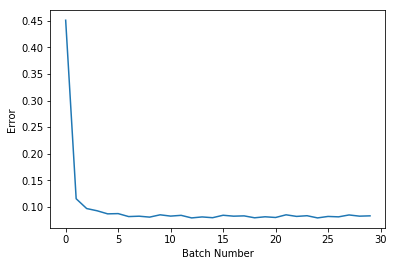

In [17]:
# Parameters
epochs = 5
batch_size = 100
errors = []
total_batches = X.shape[0]  # 60,000

for epoch in range(epochs):
    for start, end in zip(range(0, total_batches, batch_size), range(batch_size, total_batches, batch_size)):
        batch = X[start:end]
        feed_dict={visible_state_0: batch, 
                   W: prv_w, 
                   visible_bias: prv_visible_bias,  
                   hidden_bias: prv_hidden_bias}
        
        cur_w, cur_visible_bias, cur_hidden_bias = sess.run([update_w, update_visible_bias, update_hidden_bias], 
                                                             feed_dict=feed_dict)
       
        prv_w = cur_w
        prv_visible_bias = cur_visible_bias
        prv_hidden_bias = cur_hidden_bias
        
        if start % 10000 == 0:
            feed_dict={visible_state_0: X, 
                       W: cur_w, 
                       visible_bias: cur_visible_bias,  
                       hidden_bias: cur_hidden_bias}
            error = sess.run(err, feed_dict=feed_dict)
            errors.append(error)
            
    print ('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
    
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

<h3>Learned features</h3> 

We can take each hidden unit and visualize the connections between that hidden unit and each element in the input vector. In our case, we have 50 hidden units. Lets visualize those.

Let's plot the current weights:
<b>tile_raster_images</b> helps in generating an easy to grasp image from a set of samples or weights. It transform the <b>uw</b> (with one flattened image per row of size 784), into an array (of size $25\times20$) in which images are reshaped and laid out like tiles on a floor.

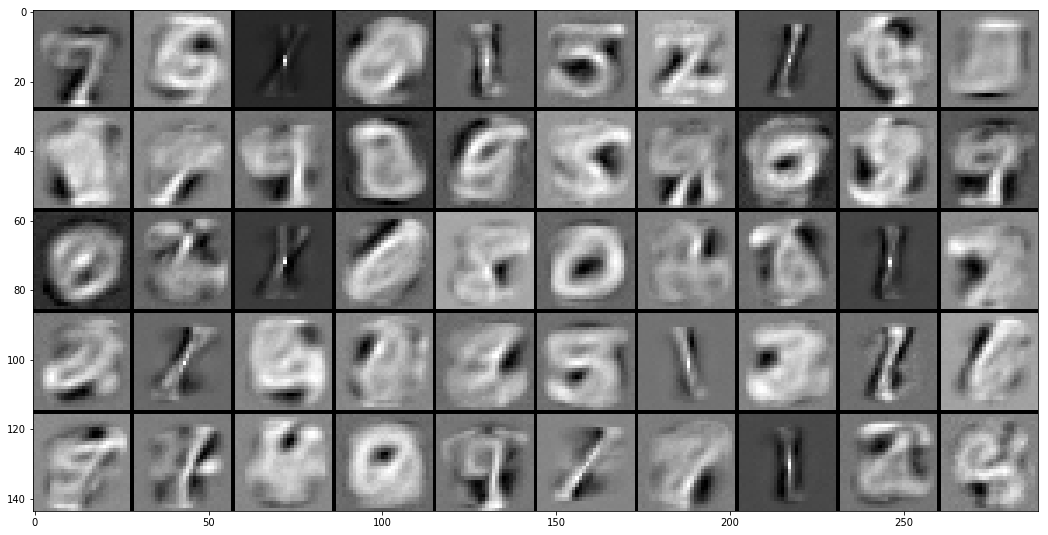

In [18]:
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Each tile in the above visualization corresponds to a vector of connections between a hidden unit and visible layer's units. 

Let's look at one of the learned weights corresponding to one of hidden units for example. In this particular square, the gray color represents weight = 0, and the whiter it is, the more positive the weights are (closer to 1). Conversely, the darker pixels are, the more negative the weights. The positive pixels will increase the probability of activation in hidden units (after multiplying by input/visible pixels), and negative pixels will decrease the probability of a unit hidden to be 1 (activated). So, why is this important?  So we can see that this specific square (hidden unit) can detect a feature (e.g. a "/" shape) and if it exists in the input.

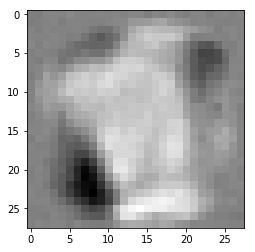

In [19]:
image = Image.fromarray(tile_raster_images(X=cur_w.T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Let's look at the reconstruction of an image now. Imagine that we have a destructed image of figure 3. Lets see if our trained network can fix it:

First we plot the image:

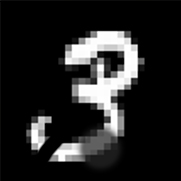

In [20]:
img = Image.open('destructed3.jpg')
img

Now let's pass this image through the net:

In [21]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

Feed the sample case into the network and reconstruct the output:

In [22]:
hh0_p = tf.nn.sigmoid(tf.matmul(visible_state_0, W) + hidden_bias)
#hh0_s = tf.nn.relu(tf.sign(hh0_p - tf.random_uniform(tf.shape(hh0_p)))) 
hh0_s = tf.round(hh0_p)
feed_dict={visible_state_0: sample_case, 
           W: prv_w,  
           hidden_bias: prv_hidden_bias}

hh0_p_val, hh0_s_val  = sess.run((hh0_p, hh0_s), feed_dict=feed_dict)
print("Probability nodes in hidden layer:" ,hh0_p_val)
print("activated nodes in hidden layer:" ,hh0_s_val)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val, tf.transpose(W)) + visible_bias)
rec_prob = sess.run(vv1_p, feed_dict={ hh0_s: hh0_s_val, W: prv_w, visible_bias: prv_visible_bias})

Probability nodes in hidden layer: [[1.67536640e-25 4.23522151e-30 7.67596165e-15 9.99996185e-01
  2.09022215e-15 3.90615376e-14 7.43238275e-14 2.70177161e-23
  1.44481783e-33 1.28918316e-06 9.00736689e-17 6.87139530e-17
  4.92229133e-35 8.50315152e-10 9.99999881e-01 1.54082678e-16
  2.88921108e-19 4.76336754e-06 3.95621546e-02 3.62132989e-17
  9.99999881e-01 1.82673872e-21 5.06939169e-18 3.23062974e-13
  3.71424863e-10 4.42992286e-19 9.26642821e-16 3.95222099e-25
  4.49342345e-19 3.73379105e-09 8.02585772e-22 1.41160885e-23
  6.54101572e-25 8.97917955e-04 9.99972820e-01 1.00000000e+00
  9.74428778e-20 1.00000000e+00 4.61993779e-13 5.24173642e-18
  2.52329956e-23 2.07148637e-25 3.28176022e-25 6.47092313e-02
  1.40886135e-21 2.26760075e-29 6.94020175e-10 3.41043956e-22
  1.02335683e-19 2.19386575e-12]]
activated nodes in hidden layer: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0

Here we plot the reconstructed image:

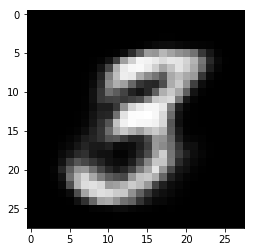

In [23]:
img = Image.fromarray(tile_raster_images(X=rec_prob, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 